In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
import sys, json, dill, re, random, time
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score as auc
from scipy.stats import spearmanr
from scipy.stats import ks_2samp as ks

from utils import reduce_memory
from utils import get_corrs_same_params, cpu_gpu_corr_stats, get_min_corr_models, get_fi_rank_corr
from utils import get_fitting_time, get_feat_imp, get_param_sets_auc, get_month_metrics
from utils import get_metrics_with_conf_int, get_null_imp_feat_counts, get_mean_and_std
from utils import get_null_imp_feat_counts, get_mean_rank_corr, get_stat_test_df

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
id_cols = ['phone_num', 'date', 'month', 'is_train', 'target']

with open('../objects/final_feats_all.json', 'r') as f_in:
    model_feats = json.load(f_in)
    
with open('../objects/final_feats_cat.json', 'r') as f_in:
    cat_feats = json.load(f_in)
    
seeds = [131, 113, 63, 73, 80, 93, 192, 79, 134, 194]

steps = np.arange(10, 301, 10)

In [5]:
metrics_path_gpu = '../metrics/lgbm_gpu_500K_test_metrics_final.csv'
df_metrics_gpu = pd.read_csv(metrics_path_gpu, sep=';')
model_names_gpu = list(df_metrics_gpu['model_name'].unique())
len(model_names_gpu)

30

In [6]:
metrics_path_cpu = '../metrics/lgbm_cpu_500K_test_metrics_final.csv'
df_metrics_cpu = pd.read_csv(metrics_path_cpu, sep=';')
model_names_cpu = list(df_metrics_cpu['model_name'].unique())
len(model_names_cpu)

30

#### get fitting time

In [7]:
get_fitting_time(df_metrics_gpu, df_metrics_cpu)
# маленькое ускорение

GPU fitting time:  186 106 96 
 CPU fitting time:  254 158 142 
 Difference:  1.4 1.5 1.5


#### save scores

In [8]:
pred_cols_gpu = []
for model_name in model_names_gpu:
    pred_cols_gpu.append(model_name[:-5])
    
pred_cols_gpu_1 = pred_cols_gpu[0:10]
pred_cols_gpu_2 = pred_cols_gpu[10:20]
pred_cols_gpu_3 = pred_cols_gpu[20:30]

In [9]:
pred_cols_cpu = []
for model_name in model_names_cpu:
    pred_cols_cpu.append(model_name[:-5])
    
pred_cols_cpu_1 = pred_cols_cpu[0:10]
pred_cols_cpu_2 = pred_cols_cpu[10:20]
pred_cols_cpu_3 = pred_cols_cpu[20:30]

In [10]:
# df_data = pd.read_csv('../objects/ml_prod_meetup_risk_sample__final.csv', index_col=None, dtype={'sex':str})
# print(df_data.shape) # (721033, 308)

In [11]:
# for model_name in model_names_gpu:
#     with open('../models/final_models/' + model_name, 'rb') as f_in:
#         model = dill.load(f_in)
#     preds = model.predict_proba(df_data[model_feats])[:,1]
#     df_data[model_name[:-5]] = pd.Series(preds) 
# # 18m 41s

In [12]:
# for model_name in model_names_cpu:
#     with open('../models/final_models/' + model_name, 'rb') as f_in:
#         model = dill.load(f_in)
#     preds = model.predict_proba(df_data[model_feats])[:,1]
#     df_data[model_name[:-5]] = pd.Series(preds) 
# # 19m 2s

In [13]:
# df_scores = df_data[id_cols + pred_cols_gpu + pred_cols_cpu]
# df_scores = reduce_memory(df_scores)
# df_scores.to_csv('../objects/lgbm_500K_scores__final.csv', sep=';', index=False)

In [ ]:
## models and scores csv are too heavy to be push to repository
### please, fit models and get its scores by yourself

#### get inference time

In [15]:
mean_gpu_inf_time = int((18*60 + 41) / 30)
mean_cpu_inf_time = int((19*60 + 2) / 30)
print('Mean GPU inference time (sec):', mean_gpu_inf_time, '\n',
      'Mean CPU inference time (sec):', mean_cpu_inf_time)

Mean GPU inference time (sec): 37 
 Mean CPU inference time (sec): 38


#### get test metric (roc auc)

In [16]:
df_scores = pd.read_csv('../objects/lgbm_500K_scores__final.csv', sep=';', index_col=None)
df_train = df_scores[df_scores['is_train']==1]
df_test = df_scores[df_scores['is_train']==0]
df_test.shape[0] # 216 484

216484

In [17]:
month_list = list(get_month_metrics(df_test, y_pred_col=pred_cols_gpu_1[0]).columns[1:])
df_metrics_cpu = get_metrics_with_conf_int(
    df_test = df_test, month_list=month_list, pred_cols=pred_cols_cpu_1
)
df_metrics_gpu = get_metrics_with_conf_int(
    df_test = df_test, month_list=month_list, pred_cols=pred_cols_gpu_1
)

In [19]:
gpu_mean, gpu_var, gpu_std, gpu_ul, gpu_ol = get_mean_and_std(df_metrics_gpu)
cpu_mean, cpu_var, cpu_std, cpu_ul, cpu_ol = get_mean_and_std(df_metrics_cpu)
print('mean CPU var:', np.mean(cpu_var), 'mean GPU var', np.mean(gpu_var))
np.mean(cpu_var) / np.mean(gpu_var) # дисперсия побольше чем у xgboost

mean CPU var: 5.703360061506376e-07 mean GPU var 5.733579695786349e-07


0.9947293600362473

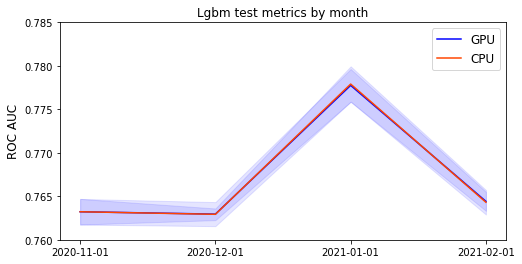

In [20]:
plt.figure(figsize=(8, 4))
x = list(df_metrics_cpu.index)
 
plt.plot(x, gpu_mean, label='GPU', color='blue')
plt.fill_between(x, gpu_ul, gpu_ol, color='b', alpha=.1)
plt.plot(x, cpu_mean, label='CPU', color='orangered')
plt.fill_between(x, cpu_ul, cpu_ol, color='b', alpha=.1)
plt.ylim(0.76, 0.785)
plt.xticks(x)
plt.ylabel('ROC AUC', fontsize=12)
plt.title("Lgbm test metrics by month")
plt.legend(fontsize=12)
plt.show()

#### get scores correlation

In [21]:
# GPU scores correlation
get_corrs_same_params(df_test, pred_cols_gpu_1)
get_corrs_same_params(df_test, pred_cols_gpu_2),
get_corrs_same_params(df_test, pred_cols_gpu_3)

min:  0.965 max:  0.968 mean:  0.967
min:  0.95 max:  0.955 mean:  0.952
min:  0.957 max:  0.962 mean:  0.96


In [22]:
# CPU scores correlation
get_corrs_same_params(df_test, pred_cols_cpu_1)
get_corrs_same_params(df_test, pred_cols_cpu_2),
get_corrs_same_params(df_test, pred_cols_cpu_3)

min:  0.965 max:  0.968 mean:  0.967
min:  0.949 max:  0.955 mean:  0.952
min:  0.957 max:  0.961 mean:  0.959


In [23]:
corr_cpu_cpu_set_2 = df_test[pred_cols_cpu_2].corr().loc[pred_cols_cpu_2]
corr_gpu_gpu_set_2 = df_test[pred_cols_gpu_2].corr().loc[pred_cols_gpu_2]

In [24]:
# # for part 'score corr CPU and GPU' in ntbk 4
# corr_cpu_cpu_set_2 = df_test[pred_cols_cpu_2].corr().loc[pred_cols_cpu_2]
# corr_gpu_gpu_set_2 = df_test[pred_cols_gpu_2].corr().loc[pred_cols_gpu_2]

# list_cpu_cpu = corr_cpu_cpu_set_2.values.tolist()
# list_cpu_cpu = [item for sublist in list_cpu_cpu for item in sublist]
# list_cpu_cpu = [x for x in list_cpu_cpu if x != 1.]

# list_gpu_gpu = corr_gpu_gpu_set_2.values.tolist()
# list_gpu_gpu = [item for sublist in list_gpu_gpu for item in sublist]
# list_gpu_gpu = [x for x in list_gpu_gpu if x != 1.]

# # print(list_cpu_cpu)
# # print(list_gpu_gpu)

In [25]:
corr_cpu_cpu_set_2 = df_test[pred_cols_cpu_2].corr().loc[pred_cols_cpu_2]

model_1, model_2, min_corr = get_min_corr_models(corr_cpu_cpu_set_2)
print(model_1, model_2, min_corr)

# CPU MIN CORR 0.949

lgbm_cpu_params_set_2_131_500K lgbm_cpu_params_set_2_134_500K 0.9493


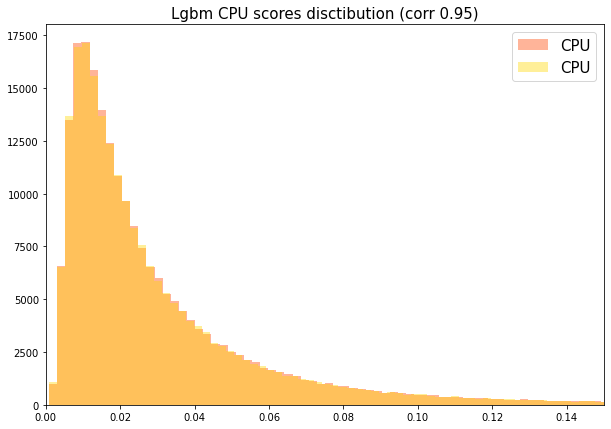

In [26]:
plt.figure(figsize=(10,7))

plt.hist(
    df_test[model_1], color='orangered', bins=400, alpha=0.4, label='CPU'
);

plt.hist(
    df_test[model_2], color='gold', bins=400, alpha=0.4, label='CPU'
);

plt.xlim(0, 0.15);
plt.title('Lgbm CPU scores disctibution (corr 0.95)', fontsize=15)
plt.legend(prop={'size': 15});
plt.rcParams.update({'font.size': 15});

In [27]:
# scores correlation between CPU and GPU - TRAIN
corr_cpu_gpu_set_1 = df_train[pred_cols_gpu_1 + pred_cols_cpu_1].corr().loc[pred_cols_cpu_1, pred_cols_gpu_1]
corr_cpu_gpu_set_2 = df_train[pred_cols_gpu_2 + pred_cols_cpu_2].corr().loc[pred_cols_cpu_2, pred_cols_gpu_2]
corr_cpu_gpu_set_3 = df_train[pred_cols_gpu_3 + pred_cols_cpu_3].corr().loc[pred_cols_cpu_3, pred_cols_gpu_3]

cpu_gpu_corr_stats(set_1 = corr_cpu_gpu_set_1, set_2 = corr_cpu_gpu_set_2, set_3 = corr_cpu_gpu_set_3)
to_plot = [np.diag(corr_cpu_gpu_set_1), np.diag(corr_cpu_gpu_set_2), np.diag(corr_cpu_gpu_set_3)]
# на трейне может быть корреляция 0.978 

Param set 1 scores correlations: min: 0.985 max: 1.0 mean 0.995
Param set 2 scores correlations: min: 0.996 max: 1.0 mean 0.999
Param set 3 scores correlations: min: 0.978 max: 1.0 mean 0.996


In [28]:
# scores correlation between CPU and GPU - TEST
corr_cpu_gpu_set_1 = df_test[pred_cols_gpu_1 + pred_cols_cpu_1].corr().loc[pred_cols_cpu_1, pred_cols_gpu_1]
corr_cpu_gpu_set_2 = df_test[pred_cols_gpu_2 + pred_cols_cpu_2].corr().loc[pred_cols_cpu_2, pred_cols_gpu_2]
corr_cpu_gpu_set_3 = df_test[pred_cols_gpu_3 + pred_cols_cpu_3].corr().loc[pred_cols_cpu_3, pred_cols_gpu_3]

cpu_gpu_corr_stats(set_1 = corr_cpu_gpu_set_1, set_2 = corr_cpu_gpu_set_2, set_3 = corr_cpu_gpu_set_3)
to_plot = [np.diag(corr_cpu_gpu_set_1), np.diag(corr_cpu_gpu_set_2), np.diag(corr_cpu_gpu_set_3)]

Param set 1 scores correlations: min: 0.975 max: 1.0 mean 0.994
Param set 2 scores correlations: min: 0.995 max: 1.0 mean 0.999
Param set 3 scores correlations: min: 0.972 max: 1.0 mean 0.995


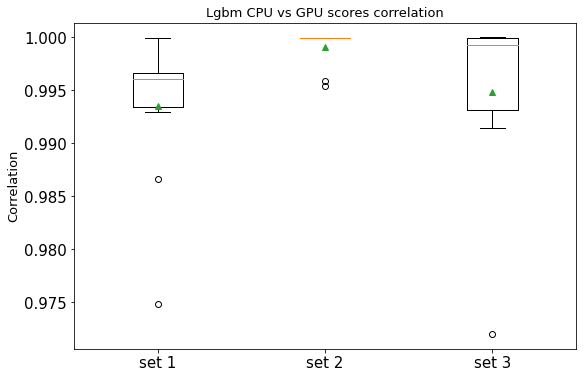

In [29]:
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)  
bp = ax.boxplot(to_plot, showmeans=True)
plt.xticks([1,2,3], ['set 1', 'set 2', 'set 3'])
plt.ylabel('Correlation', fontsize=13)
plt.title("Lgbm CPU vs GPU scores correlation", fontsize=13)
plt.show()
# все выще 0.96

In [30]:
model_1, model_2, min_corr = get_min_corr_models(corr_cpu_gpu_set_1)
print(model_1, model_2, min_corr)
min(np.diag(corr_cpu_gpu_set_1))

lgbm_gpu_params_set_1_79_500K lgbm_cpu_params_set_1_93_500K 0.9652


0.9748688735109206

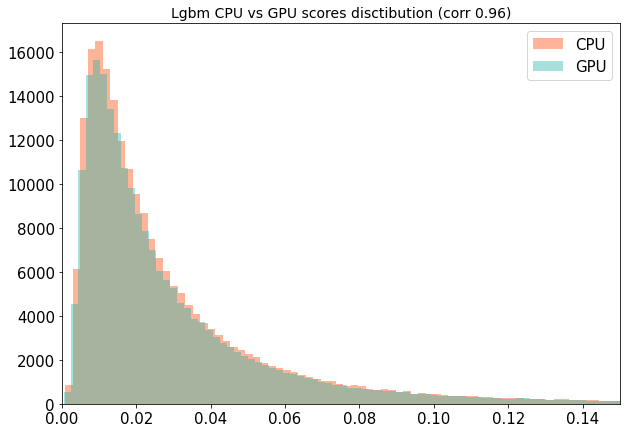

In [31]:
plt.figure(figsize=(10,7))

plt.hist(
    df_test['lgbm_gpu_params_set_1_79_500K'], color='orangered', bins=400, alpha=0.4, label='CPU'
);

plt.hist(
    df_test['lgbm_cpu_params_set_1_93_500K'], color='lightseagreen', bins=400, alpha=0.4, label='GPU'
);

plt.xlim(0, 0.15);
plt.title('Lgbm CPU vs GPU scores disctibution (corr 0.96)', fontsize=14)
plt.legend();
plt.rcParams.update({'font.size': 15}); # побольше отличается чем xgb

#### stat test

In [32]:
# CPU vs CPU
ks_cpu_1 = get_stat_test_df(df_test, pred_cols_cpu_1, pred_cols_cpu_1)

Cnt models pairs with same scores distribution 84
Cnt models pairs different scores distribution 6


In [33]:
ks_cpu_2 = get_stat_test_df(df_test, pred_cols_cpu_2, pred_cols_cpu_2)

Cnt models pairs with same scores distribution 90
Cnt models pairs different scores distribution 0


In [34]:
ks_cpu_3 = get_stat_test_df(df_test, pred_cols_cpu_3, pred_cols_cpu_3)

Cnt models pairs with same scores distribution 90
Cnt models pairs different scores distribution 0


In [35]:
# GPU vs GPU
ks_gpu_1 = get_stat_test_df(df_test, pred_cols_gpu_1, pred_cols_gpu_1)

Cnt models pairs with same scores distribution 90
Cnt models pairs different scores distribution 0


In [36]:
ks_gpu_2 = get_stat_test_df(df_test, pred_cols_gpu_2, pred_cols_gpu_2)

Cnt models pairs with same scores distribution 90
Cnt models pairs different scores distribution 0


In [37]:
ks_gpu_3 = get_stat_test_df(df_test, pred_cols_gpu_3, pred_cols_gpu_3)

Cnt models pairs with same scores distribution 90
Cnt models pairs different scores distribution 0


In [38]:
# CPU vs GPU
ks_cpu_gpu_1 = get_stat_test_df(df_test, pred_cols_gpu_1, pred_cols_cpu_1)

Cnt models pairs with same scores distribution 96
Cnt models pairs different scores distribution 4


In [39]:
ks_cpu_gpu_2 = get_stat_test_df(df_test, pred_cols_gpu_2, pred_cols_cpu_2)

Cnt models pairs with same scores distribution 100
Cnt models pairs different scores distribution 0


In [40]:
ks_cpu_gpu_3 = get_stat_test_df(df_test, pred_cols_gpu_3, pred_cols_cpu_3)

Cnt models pairs with same scores distribution 100
Cnt models pairs different scores distribution 0


**за редким исключением, lgbm модели дают одинаковые распределения скоров**

#### get feature importance CPU

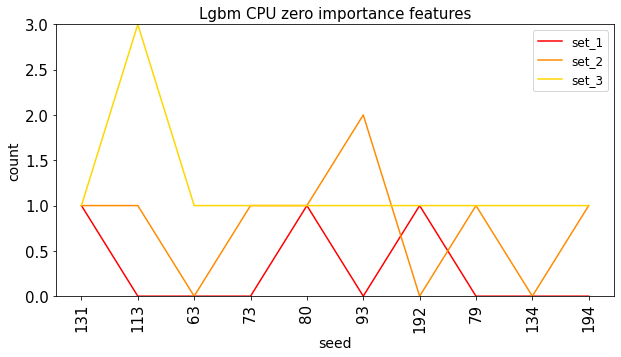

In [41]:
fi_cpu_1, fi_cpu_2, fi_cpu_3 = get_null_imp_feat_counts(model_names = model_names_cpu, model_type='lgbm')

plt.figure(figsize=(10, 5))
x = range(len(fi_cpu_1))
 
plt.plot(x, fi_cpu_1, label='set_1', color='red')
plt.plot(x, fi_cpu_2, label='set_2', color='darkorange')
plt.plot(x, fi_cpu_3, label='set_3', color='gold')
plt.ylim(0, 3)
plt.xticks(x, seeds, rotation='vertical')
plt.xlabel('seed', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title("Lgbm CPU zero importance features", fontsize=15)
plt.legend(loc='upper right', prop={'size': 12})
plt.show()

In [42]:
# cpu_corr_set_1 = get_mean_rank_corr(model_names_1=model_names_cpu[0:10], model_names_2=model_names_cpu[0:10],
#                                     model_type='lgbm')
# cpu_corr_set_2 = get_mean_rank_corr(model_names_1=model_names_cpu[10:20], model_names_2=model_names_cpu[10:20],
#                                     model_type='lgbm')
# cpu_corr_set_3 = get_mean_rank_corr(model_names_1=model_names_cpu[20:30], model_names_2=model_names_cpu[20:30],
#                                     model_type='lgbm')

# cpu_corr_set_1.to_csv('../metrics/lgbm_cpu_corr_set_1.csv', index=False)
# cpu_corr_set_2.to_csv('../metrics/lgbm_cpu_corr_set_2.csv', index=False)
# cpu_corr_set_3.to_csv('../metrics/lgbm_cpu_corr_set_3.csv', index=False)
# # 57 sec

In [43]:
cpu_corr_set_1 = pd.read_csv('../metrics/lgbm_cpu_corr_set_1.csv')
cpu_corr_set_2 = pd.read_csv('../metrics/lgbm_cpu_corr_set_2.csv')
cpu_corr_set_3 = pd.read_csv('../metrics/lgbm_cpu_corr_set_3.csv')

In [44]:
print(get_min_corr_models(cpu_corr_set_1))
print(get_min_corr_models(cpu_corr_set_2))
print(get_min_corr_models(cpu_corr_set_3))

('lgbm_cpu_params_set_1_134_500K.dilllgbm_cpu_params_set_1_63_500K.dill', 0, 0.903)
('lgbm_cpu_params_set_2_134_500K.dilllgbm_cpu_params_set_2_113_500K.dill', 7, 0.921)
('lgbm_cpu_params_set_3_113_500K.dilllgbm_cpu_params_set_3_194_500K.dill', 9, 0.915)


In [45]:
cpu_mean_1, cpu_var_1, cpu_std_1, cpu_ul_1, cpu_ol_1  = get_mean_and_std(cpu_corr_set_1)
cpu_mean_2, cpu_var_2, cpu_std_2, cpu_ul_2, cpu_ol_2 = get_mean_and_std(cpu_corr_set_2)
cpu_mean_3, cpu_var_3, cpu_std_3, cpu_ul_3, cpu_ol_3 = get_mean_and_std(cpu_corr_set_3)

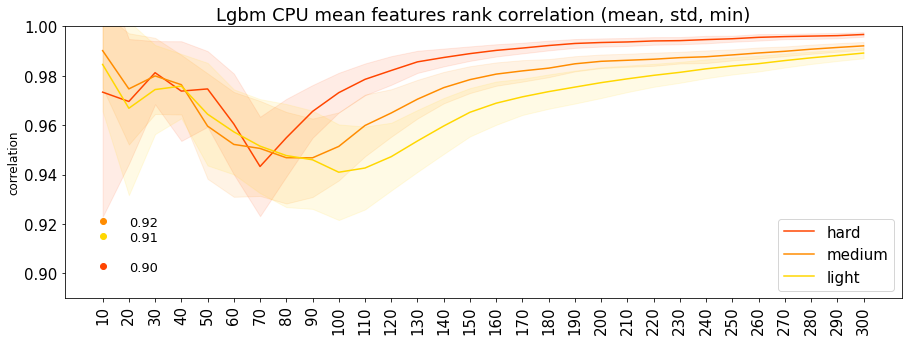

In [46]:
plt.figure(figsize=(15, 5))
x = list(cpu_corr_set_1.index)
 
plt.plot(x, cpu_mean_1, label='hard', color='orangered')
plt.plot(x, cpu_mean_2, label='medium', color='darkorange')
plt.plot(x, cpu_mean_3, label='light', color='gold')

plt.fill_between(x, cpu_ul_1, cpu_ol_1, color='orangered', alpha=.1)
plt.fill_between(x, cpu_ul_2, cpu_ol_2, color='darkorange', alpha=.1)
plt.fill_between(x, cpu_ul_3, cpu_ol_3, color='gold', alpha=.1)

plt.plot(0, 0.903, 'o', color='orangered');
plt.text(1, 0.901, '0.90', fontsize=13)
plt.plot(0, 0.921, 'o', color='darkorange');
plt.text(1, 0.919, '0.92', fontsize=13)
plt.plot(0, 0.915, 'o', color='gold');
plt.text(1, 0.913, '0.91', fontsize=13)

plt.ylim(0.89, 1)

plt.xticks(x, steps, rotation='vertical')
plt.ylabel('correlation', fontsize=12)
plt.title("Lgbm CPU mean features rank correlation (mean, std, min)")
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

#### get feature importances GPU

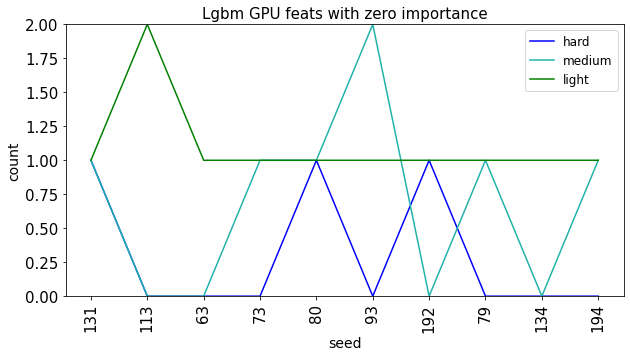

In [47]:
fi_gpu_1, fi_gpu_2, fi_gpu_3 = get_null_imp_feat_counts(model_names = model_names_gpu, model_type='lgbm')

plt.figure(figsize=(10, 5))
x = range(len(fi_gpu_1))
 
plt.plot(x, fi_gpu_1, label='hard', color='blue')
plt.plot(x, fi_gpu_2, label='medium', color='lightseagreen')
plt.plot(x, fi_gpu_3, label='light', color='green')
plt.ylim(0, 2)
plt.xticks(x, seeds, rotation='vertical')
plt.xlabel('seed', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title("Lgbm GPU feats with zero importance", fontsize=15)
plt.legend(fontsize=12)
plt.show()

In [48]:
# gpu_corr_set_1 = get_mean_rank_corr(model_names_1=model_names_gpu[0:10], model_names_2=model_names_gpu[0:10],
#                                     model_type='lgbm')
# gpu_corr_set_2 = get_mean_rank_corr(model_names_1=model_names_gpu[10:20], model_names_2=model_names_gpu[10:20],
#                                     model_type='lgbm')
# gpu_corr_set_3 = get_mean_rank_corr(model_names_1=model_names_gpu[20:30], model_names_2=model_names_gpu[20:30],
#                                     model_type='lgbm')

# gpu_corr_set_1.to_csv('../metrics/lgbm_gpu_corr_set_1.csv', index=False)
# gpu_corr_set_2.to_csv('../metrics/lgbm_gpu_corr_set_2.csv', index=False)
# gpu_corr_set_3.to_csv('../metrics/lgbm_gpu_corr_set_3.csv', index=False)
# # 57 сек

In [49]:
gpu_corr_set_1 = pd.read_csv('../metrics/lgbm_gpu_corr_set_1.csv')
gpu_corr_set_2 = pd.read_csv('../metrics/lgbm_gpu_corr_set_2.csv')
gpu_corr_set_3 = pd.read_csv('../metrics/lgbm_gpu_corr_set_3.csv')

In [50]:
print(get_min_corr_models(gpu_corr_set_1.iloc[0:1, 0:90]))
print(get_min_corr_models(gpu_corr_set_2.iloc[0:1, 0:90]))
print(get_min_corr_models(gpu_corr_set_3.iloc[0:1, 0:90]))

('lgbm_gpu_params_set_1_63_500K.dilllgbm_gpu_params_set_1_93_500K.dill', 0, 0.927)
('lgbm_gpu_params_set_2_134_500K.dilllgbm_gpu_params_set_2_194_500K.dill', 0, 0.976)
('lgbm_gpu_params_set_3_131_500K.dilllgbm_gpu_params_set_3_79_500K.dill', 0, 0.964)


In [51]:
gpu_mean_1, gpu_var_1, gpu_std_1, gpu_ul_1, gpu_ol_1  = get_mean_and_std(gpu_corr_set_1)
gpu_mean_2, gpu_var_2, gpu_std_2, gpu_ul_2, gpu_ol_2 = get_mean_and_std(gpu_corr_set_2)
gpu_mean_3, gpu_var_3, gpu_std_3, gpu_ul_3, gpu_ol_3 = get_mean_and_std(gpu_corr_set_3)

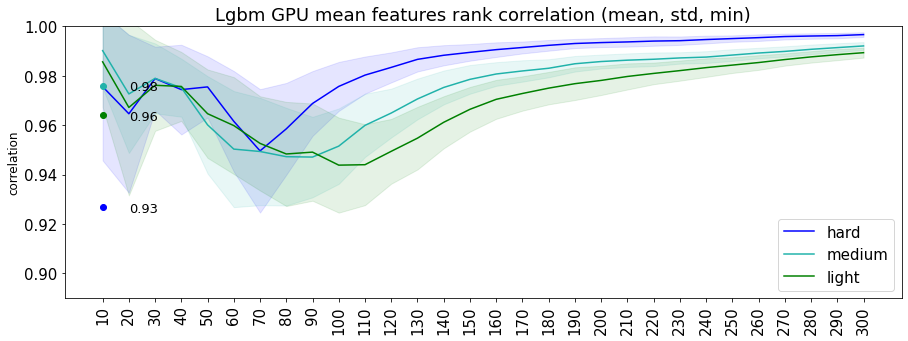

In [59]:
plt.figure(figsize=(15, 5))
x = list(gpu_corr_set_1.index)
 
plt.plot(x, gpu_mean_1, label='hard', color='blue')
plt.plot(x, gpu_mean_2, label='medium', color='lightseagreen')
plt.plot(x, gpu_mean_3, label='light', color='green')

plt.fill_between(x, gpu_ul_1, gpu_ol_1, color='blue', alpha=.1)
plt.fill_between(x, gpu_ul_2, gpu_ol_2, color='lightseagreen', alpha=.1)
plt.fill_between(x, gpu_ul_3, gpu_ol_3, color='green', alpha=.1)

plt.plot(0, 0.927, 'o', color='blue');
plt.text(1, 0.925, '0.93', fontsize=13)
plt.plot(0, 0.976, 'o', color='lightseagreen');
plt.text(1, 0.974, '0.98', fontsize=13);
plt.plot(0, 0.964, 'o', color='green');
plt.text(1, 0.962, '0.96', fontsize=13)


plt.ylim(0.89, 1)
plt.xticks(x, steps, rotation='vertical')
plt.ylabel('correlation', fontsize=12)
plt.title("Lgbm GPU mean features rank correlation (mean, std, min)")
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

# чем меньше фичей занулялось - тем выше средняя корреляция

#### get feature importances CPU vs GPU

In [53]:
# c_g_corr_set_1 = get_mean_rank_corr(model_names_1=model_names_gpu[0:10], model_names_2=model_names_cpu[0:10],
#                                     model_type='lgbm')
# c_g_corr_set_2 = get_mean_rank_corr(model_names_1=model_names_gpu[10:20], model_names_2=model_names_cpu[10:20],
#                                     model_type='lgbm')
# c_g_corr_set_3 = get_mean_rank_corr(model_names_1=model_names_gpu[20:30], model_names_2=model_names_cpu[20:30],
#                                     model_type='lgbm')

# c_g_corr_set_1.to_csv('../metrics/lgbm_c_g_corr_set_1.csv', index=False)
# c_g_corr_set_2.to_csv('../metrics/lgbm_c_g_corr_set_2.csv', index=False)
# c_g_corr_set_3.to_csv('../metrics/lgbm_c_g_corr_set_3.csv', index=False)

In [54]:
c_g_corr_set_1 = pd.read_csv('../metrics/lgbm_c_g_corr_set_1.csv')
c_g_corr_set_2 = pd.read_csv('../metrics/lgbm_c_g_corr_set_2.csv')
c_g_corr_set_3 = pd.read_csv('../metrics/lgbm_c_g_corr_set_3.csv')

In [55]:
print(get_min_corr_models(c_g_corr_set_1))
print(get_min_corr_models(c_g_corr_set_2))
print(get_min_corr_models(c_g_corr_set_3))

('lgbm_gpu_params_set_1_73_500K.dilllgbm_cpu_params_set_1_63_500K.dill', 0, 0.891)
('lgbm_gpu_params_set_2_131_500K.dilllgbm_cpu_params_set_2_63_500K.dill', 6, 0.92)
('lgbm_gpu_params_set_3_192_500K.dilllgbm_cpu_params_set_3_194_500K.dill', 8, 0.916)


In [56]:
print(get_min_corr_models(c_g_corr_set_1.iloc[0:1, 0:90]))
print(get_min_corr_models(c_g_corr_set_2.iloc[0:1, 0:90]))
print(get_min_corr_models(c_g_corr_set_3.iloc[0:1, 0:90]))

('lgbm_gpu_params_set_1_73_500K.dilllgbm_cpu_params_set_1_63_500K.dill', 0, 0.891)
('lgbm_gpu_params_set_2_134_500K.dilllgbm_cpu_params_set_2_194_500K.dill', 0, 0.976)
('lgbm_gpu_params_set_3_131_500K.dilllgbm_cpu_params_set_3_79_500K.dill', 0, 0.964)


In [57]:
c_g_mean_1, c_g_var_1, c_g_std_1, c_g_ul_1, c_g_ol_1 = get_mean_and_std(c_g_corr_set_1)
c_g_mean_2, c_g_var_2, c_g_std_2, c_g_ul_2, c_g_ol_2 = get_mean_and_std(c_g_corr_set_2)
c_g_mean_3, c_g_var_3, c_g_std_3, c_g_ul_3, c_g_ol_3 = get_mean_and_std(c_g_corr_set_3)

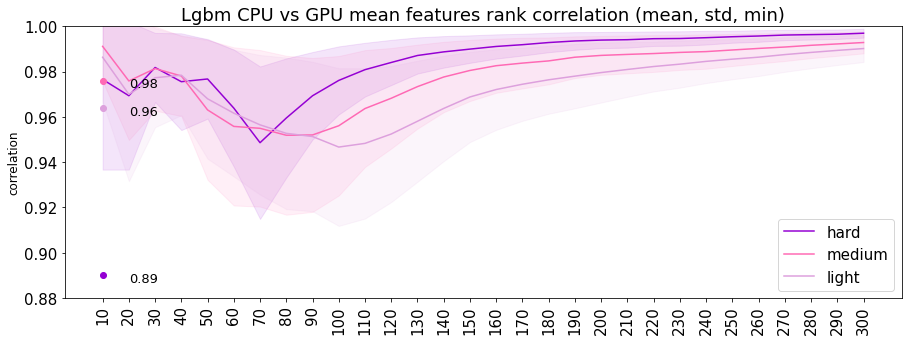

In [58]:
plt.figure(figsize=(15, 5))
x = list(cpu_corr_set_1.index)
 
plt.plot(x, c_g_mean_1, label='hard', color='darkviolet')
plt.plot(x, c_g_mean_2, label='medium', color='hotpink')
plt.plot(x, c_g_mean_3, label='light', color='plum')

plt.fill_between(x, c_g_ul_1, c_g_ol_1, color='darkviolet', alpha=.1)
plt.fill_between(x, c_g_ul_2, c_g_ol_2, color='hotpink', alpha=.1)
plt.fill_between(x, c_g_ul_3, c_g_ol_3, color='plum', alpha=.1)

plt.plot(0, 0.890, 'o', color='darkviolet');
plt.text(1, 0.887, '0.89', fontsize=13)
plt.plot(0, 0.976, 'o', color='hotpink');
plt.text(1, 0.973, '0.98', fontsize=13)
plt.plot(0, 0.964, 'o', color='plum');
plt.text(1, 0.961, '0.96', fontsize=13)

plt.ylim(0.88, 1)

plt.xticks(x, steps, rotation='vertical')
plt.ylabel('correlation', fontsize=12)
plt.title("Lgbm CPU vs GPU mean features rank correlation (mean, std, min)")
plt.legend(loc='lower right', prop={'size': 15})
plt.show()